Pare esse exercício serão disponibilizados três arquivos: ***amazonas.csv*** que contém dados históricos de desflorestamento nos municipios do Amazonas no ano de 2014, ***estados.csv*** que contém uma lista com o nome, uf e codigo dos estados brasileiros e ***municipios.csv*** que contém o nome de todos os municípios brasileiros e suas respectivas localizações no globo (longitude e latitude).

O objetivo do exercício é gerar um relatório sobre o desflorestamento nos municípios do Amazonas com a visualização dos dados sobre o mapa do Brasil.
Para isso será necessário relacionar ambas as três tabelas de forma que seja associado a posição geográfica (longitude e latitude) dos municípios aos dados de desflorestamento.


In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
#biblioteca para plotar no mapa
import mplleaflet

In [2]:
# Aditional packages
import os

In [3]:
# Important directories and other constants
DATA_DIR = 'data'
AMAZONAS = 'amazonas.csv'
STATES = 'estados.csv'
CITIES = 'municipios.csv'

DESFLORESTAMENTO = 'Desflorestamento Relativo'
MINERACAO = 'Mineração'
NORM_MINING = 'Mineração Normalizada'
NORM_DEFOREST = "Desflorestamento relativo normalizado"
SCALE_FACTOR = 15 # empiric scale factor
INVALID_MINING = -1
ACIMA_MEDIA = 'Desflorestamento > Média'

UNUSED_COLUMNS = ['Hidrografia', 'Mosaico de Ocupações', 'Outros', 
                'Pasto com Solo Exposto', 'Pasto Limpo', 'Pasto Sujo',
                   'Regeneração com Pasto', 'Reflorestamento', 'Não Floresta',
                  'nome', 'Total Geral', 'capital', 'Vegetação Secundária']

In [4]:
#começaremos importando todas as tabelas
df_amazonas = pd.read_csv(os.path.join(DATA_DIR, AMAZONAS))
df_states = pd.read_csv(os.path.join(DATA_DIR, STATES))
df_cities = pd.read_csv(os.path.join(DATA_DIR, CITIES))

Vamos da uma olhada no jeito de cada tabela

In [5]:
df_amazonas.head()

,Municípios,Agricultura Anual,Área não Observada,Área Urbana,Desflorestamento 2014,Floresta,Hidrografia,Mineração,Mosaico de Ocupações,Não Floresta,Outros,Pasto com Solo Exposto,Pasto Limpo,Pasto Sujo,Reflorestamento,Regeneração com Pasto,Vegetação Secundária,Total Geral
0,Alvaraes,NaN,0.07,1.90,2.75,"5,415.56",133.87,NaN,101.08,43.26,5.36,NaN,2.92,1.02,NaN,5.13,198.55,"5,911.46"
1,Amatura,NaN,NaN,2.05,0.36,"4,220.22",209.41,NaN,15.87,216.55,3.76,NaN,4.03,NaN,NaN,11.44,71.74,"4,755.42"
2,Anama,NaN,0.86,0.89,0.44,"2,001.85",229.30,NaN,6.90,34.81,13.11,NaN,2.02,0.87,NaN,NaN,160.61,"2,451.66"
3,Anori,NaN,0.15,2.77,0.59,"4,646.53",436.07,NaN,17.12,636.01,4.70,NaN,8.05,0.52,NaN,NaN,41.98,"5,794.49"
4,Apui,NaN,6.71,5.91,80.19,"51,396.43",213.50,NaN,8.76,622.87,7.18,NaN,812.61,329.85,NaN,208.13,546.18,"54,238.32"


In [6]:
df_states.head()

,codigo_uf,uf,nome
0,11,RO,Rondônia
1,12,AC,Acre
2,13,AM,Amazonas
3,14,RR,Roraima
4,15,PA,Pará


In [7]:
df_cities.head()

,codigo_ibge,nome,latitude,longitude,capital,codigo_uf
0,5200050,Abadia de Goiás,-16.75730,-49.4412,0,52
1,3100104,Abadia dos Dourados,-18.48310,-47.3916,0,31
2,5200100,Abadiânia,-16.19700,-48.7057,0,52
3,3100203,Abaeté,-19.15510,-45.4444,0,31
4,1500107,Abaetetuba,-1.72183,-48.8788,0,15


Apos carregar os dados devemos associar as tabelas de estados e municípios e selecionar apenas os municípios do Amazonas

Note que nos dados provenientes da tabela ***municipios.csv*** o nome dos municípios estão todos acentuados, no entanto na tabela amazonas os nomes estão sem acento. Logo é necessario remover os acentos dos nomes da tabela ***municipios.csv***.

In [8]:
from unicodedata import normalize
# use esta funçao para remover acentos
def remove_acentos_python3(txt):
    return str(normalize('NFKD', txt).encode('ASCII', 'ignore'), 'utf-8')
def remove_acentos_python2(txt):
    return normalize('NFKD', txt.decode('utf-8')).encode('ASCII', 'ignore')

# ex
print(remove_acentos_python3("Olá!")) #change to python3, the one I'm using

Ola!


In [9]:
df_cities['nome'] = df_cities['nome'].apply(remove_acentos_python3)

In [10]:
df_cities.head()

,codigo_ibge,nome,latitude,longitude,capital,codigo_uf
0,5200050,Abadia de Goias,-16.75730,-49.4412,0,52
1,3100104,Abadia dos Dourados,-18.48310,-47.3916,0,31
2,5200100,Abadiania,-16.19700,-48.7057,0,52
3,3100203,Abaete,-19.15510,-45.4444,0,31
4,1500107,Abaetetuba,-1.72183,-48.8788,0,15


Em seguida relacione as tabelas municipios e amazonas.

In [11]:
# rename column "name", because we already have a "name" column in df_cities
df_states.rename(columns={'nome': 'estado'}, inplace=True)
df_states.head()

,codigo_uf,uf,estado
0,11,RO,Rondônia
1,12,AC,Acre
2,13,AM,Amazonas
3,14,RR,Roraima
4,15,PA,Pará


In [12]:
df_brazil = df_cities.merge(df_states, how='left', on=['codigo_uf'])
print('Dimensões antigas:', df_cities.shape, 'Dimensões novas:', df_brazil.shape)
df_brazil.head()

Dimensões antigas: (5570, 6) Dimensões novas: (5570, 8)


,codigo_ibge,nome,latitude,longitude,capital,codigo_uf,uf,estado
0,5200050,Abadia de Goias,-16.75730,-49.4412,0,52,GO,Goiás
1,3100104,Abadia dos Dourados,-18.48310,-47.3916,0,31,MG,Minas Gerais
2,5200100,Abadiania,-16.19700,-48.7057,0,52,GO,Goiás
3,3100203,Abaete,-19.15510,-45.4444,0,31,MG,Minas Gerais
4,1500107,Abaetetuba,-1.72183,-48.8788,0,15,PA,Pará


In [13]:
df_cities_amazonas = df_brazil[df_brazil['uf'] == 'AM']
print('Dimensões df_amazonas:', df_amazonas.shape, 'Dimensões df_cities_amazonas:', df_cities_amazonas.shape)

Dimensões df_amazonas: (62, 18) Dimensões df_cities_amazonas: (62, 8)


In [14]:
df_forest = df_amazonas.merge(df_cities_amazonas, left_on='Municípios', right_on='nome')
print('Dimensões dataframe Amazonas completo:', df_forest.shape)
df_forest.drop(UNUSED_COLUMNS, axis=1, inplace=True)
df_forest

Dimensões dataframe Amazonas completo: (62, 26)


,Municípios,Agricultura Anual,Área não Observada,Área Urbana,Desflorestamento 2014,Floresta,Mineração,codigo_ibge,latitude,longitude,codigo_uf,uf,estado
0,Alvaraes,NaN,0.07,1.90,2.75,"5,415.56",NaN,1300029,-3.22727,-64.8007,13,AM,Amazonas
1,Amatura,NaN,NaN,2.05,0.36,"4,220.22",NaN,1300060,-3.37455,-68.2005,13,AM,Amazonas
2,Anama,NaN,0.86,0.89,0.44,"2,001.85",NaN,1300086,-3.56697,-61.3963,13,AM,Amazonas
3,Anori,NaN,0.15,2.77,0.59,"4,646.53",NaN,1300102,-3.74603,-61.6575,13,AM,Amazonas
4,Apui,NaN,6.71,5.91,80.19,"51,396.43",NaN,1300144,-7.19409,-59.8960,13,AM,Amazonas
...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,Tefe,0.0,0.35,11.60,8.79,"22,189.29",NaN,1304203,-3.36822,-64.7193,13,AM,Amazonas
58,Tonantins,NaN,NaN,3.91,0.36,"5,976.36",NaN,1304237,-2.86582,-67.7919,13,AM,Amazonas
59,Uarini,NaN,0.21,2.45,3.46,"9,466.29",NaN,1304260,-2.99609,-65.1133,13,AM,Amazonas
60,Urucara,NaN,15.98,4.11,1.45,"26,495.54",1.78,1304302,-2.52936,-57.7538,13,AM,Amazonas


### Questão


Plote no mapa do Brasil indicadores  de desflorestamento para todos os municipios do amazonas.
Os indicadores devem ser relativos ao tamanho da floresta de cada município dando destaque aos municipios que com desflorestamento acima da média.

#### Dica

O desflorestamento relativo é dado pelas colunas ***Desflorestamento 2014*** / ***Floresta*** da tabela ***amazonas.csv***.
Note que a coluna ***Floresta*** não é numérica e contém ',' separando os milhares, sendo necessário remover a ',' de todas as entradas e logo após converter os valores para float.

Podem ser usadas todas as dicas relevantes sobre apresentação de figuras  nos textos *Making Data Meaningful* e *Ten Simple Rules for Better Figures*.

Para plotar sobre o mapa, pode-se usar a funções normais do matplotlib e ao fim chamar a função **mplleaflet.display()**.

In [15]:
def str_to_float(number):
    return float(number.replace(',', '')) if(isinstance(number, str)) else number

def test_str_tofloat():
    tests = ['98', '7,900', '876.2', '12,986.91']
    gt = [98, 7900, 876.2, 12986.91]
    for i, n in enumerate(tests):
        if str_to_float(n) != gt[i]:
            print('FAIL! Expected: ', i, 'Got:', str_to_float(n))
            return
    print('str_to_float working!')
test_str_tofloat()
    

str_to_float working!


In [16]:
#calcula as informações do desflorestamento
df_forest['Floresta'] = df_forest['Floresta'].apply(str_to_float)
df_forest[DESFLORESTAMENTO] = df_forest['Desflorestamento 2014']/df_forest['Floresta']

### Fator de Escala
Para representar as cidades no mapa com indicadores relativos ao tamanho da floresta, optou-se por representar municípios com grandes áreas de floresta por pontos maiores e municípios com pequenas áreas de florestas por pontos menores. 

Para que essa informação se adeque ao tamanho do mapa e preserve a diferença proporcional entre os municípios, aplica-se um **fator de escala** determinado empíricamente.

In [17]:
#codigo de plot
fig = plt.figure(figsize=(8,8))

plt.scatter(df_forest['longitude'], df_forest['latitude'], marker='o',
            s=df_forest['Floresta']/SCALE_FACTOR,
            c = df_forest[DESFLORESTAMENTO],
            cmap='YlOrRd')

#transforma o plot em localizações no mapa
mplleaflet.display(fig=fig)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/display.py:694: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


## Mapa 1
No mapa, podemos ver que os municípios com muita área de floresta apresentam um desmatamento relativo baixo, representado pela cor amarela clara. À medida que a intensidade do desmatamento relativo aumenta, a cor se torna mais intensa, passando por tons laranjas até o vermelho. Contudo, esse mapa ainda não nos mostra com precisão quais são os municípios com desmatamento relativo acima da média, para isso, vamos dividí-los em dois grupos:

Grupo 1: Desmatamento relativo abaixo ou igual à média
Grupo 2: Desmatamento relativo acima da média

In [18]:
mean_deforest = df_forest[DESFLORESTAMENTO].mean()
g1 = df_forest[df_forest[DESFLORESTAMENTO] <= mean_deforest]
g2 = df_forest[df_forest[DESFLORESTAMENTO] > mean_deforest]

In [19]:
fig = plt.figure(figsize=(8,8))

#plt.plot(df_forest['longitude'], df_forest['latitude'], 'o', s=df_forest['Floresta'])

plt.scatter(g1['longitude'], g1['latitude'], marker='o',
            s=g1['Floresta']/SCALE_FACTOR,
            c = "blue", 
            alpha=0.8)

plt.scatter(g2['longitude'], g2['latitude'], marker='o',
            s=g2['Floresta']/SCALE_FACTOR*2,
            c = 'red', alpha=0.9)

#transforma o plot em localizações no mapa
mplleaflet.display(fig=fig)

## Mapa 2
Neste segundo mapa, podemos observar os municípios do "Grupo 2" em vermelho, e aqueles do "Grupo 1" em azul. O tamanho das marcações é proporcional dentro de cada grupo, mas não deve ser comparado entre grupos diferentes, pois a escala do "Grupo 2" foi ampliada para possibilitar melhor visualização dos municípios com desmatamento relativo acima da média, visto que a maioria destes apresenta áreas de florestas menores.

### Questão


Segundo os dados, a mineração nos municípios tem alguma relação com o desflorestamento acima da média?
Mostre suas conclusões por tabelas e plots no mapa.

In [20]:
df_forest[ACIMA_MEDIA] = df_forest[DESFLORESTAMENTO] > mean_deforest 

In [21]:
df_forest.sort_values(by=DESFLORESTAMENTO, ascending=False).iloc[0:10, :].loc[:,['Municípios', MINERACAO, DESFLORESTAMENTO, ACIMA_MEDIA]]

,Municípios,Mineração,Desflorestamento Relativo,Desflorestamento > Média
61,Urucurituba,0.03,0.004762,True
12,Boca do Acre,1.90,0.003682,True
18,Careiro da Varzea,NaN,0.003537,True
45,Parintins,NaN,0.002704,True
34,Labrea,2.25,0.002081,True
27,Iranduba,0.39,0.001729,True
6,Autazes,NaN,0.001716,True
4,Apui,NaN,0.001560,True
8,Barreirinha,NaN,0.001237,True
28,Itacoatiara,0.03,0.001193,True


## Tabela 1

A tabela mostra os 10 municípios com maiores índices de desflorestamento relativo em 2014. Todos eles possuem desflorestamento acima da média, porém não é possível dizer que a mineração cresce ou descresce com os valores de desflorestamento. Observa-se a ausência de valores de mineração para metade dos registros.

In [22]:
df_forest.sort_values(by=MINERACAO, ascending=False).iloc[0:10, :].loc[:,['Municípios', MINERACAO, DESFLORESTAMENTO, ACIMA_MEDIA]]

,Municípios,Mineração,Desflorestamento Relativo,Desflorestamento > Média
37,Manaus,16.89,0.000245,False
44,Novo Aripuana,10.85,0.000596,True
40,Maues,6.70,0.000380,False
34,Labrea,2.25,0.002081,True
12,Boca do Acre,1.90,0.003682,True
60,Urucara,1.78,0.000055,False
47,Presidente Figueiredo,1.48,0.000292,False
48,Rio Preto da Eva,0.88,0.000212,False
35,Manacapuru,0.86,0.000702,True
27,Iranduba,0.39,0.001729,True


## Tabela 2
Olhando agora para os 10 municípios com atividade mineradora mais intensa, observa-se que metade deles possui desflorestamento relativo abaixo da média. Assim, não é possível tirar nenhuma conclusão definitiva com os dados observados nessa tabela e na anterior.

## Preparação dos dados

Percebe-se que há diversos registros para os quais não estão disponíveis os dados sobre mineração. Vamos adotar uma política de tratamento de nulos de ignorar esses valores e seguir a análise apenas com aqueles municípios cujo valor de mineração seja um número. Sem maiores informações a respeito de como e em que circunstâncias o dado foi coletado, vamos assumir que nos municípios com nulos (NaN) não há atividade mineradora significativa.

Em seguida, vamos armazenar em nosso *dataframe* os dados normalizados sobre mineração e desflorestamento, pois assim, poderemos compará-los em uma mesma ordem de grandeza.

In [23]:
# df_forest[MINERACAO].fillna(INVALID_MINING, inplace=True)
df_mining = df_forest.dropna(subset=[MINERACAO])
df_mining.head()

,Municípios,Agricultura Anual,Área não Observada,Área Urbana,Desflorestamento 2014,Floresta,Mineração,codigo_ibge,latitude,longitude,codigo_uf,uf,estado,Desflorestamento Relativo,Desflorestamento > Média
7,Barcelos,NaN,0.23,4.27,1.91,100948.88,0.01,1300409,-0.983373,-62.9311,13,AM,Amazonas,0.000019,False
12,Boca do Acre,NaN,17.96,5.49,71.96,19542.90,1.90,1300706,-8.742320,-67.3919,13,AM,Amazonas,0.003682,True
14,Caapiranga,NaN,9.68,2.89,0.76,8619.87,0.01,1300839,-3.315370,-61.2206,13,AM,Amazonas,0.000088,False
27,Iranduba,0.3,1.89,33.64,2.24,1295.24,0.39,1301852,-3.274790,-60.1900,13,AM,Amazonas,0.001729,True
28,Itacoatiara,0.0,151.70,16.14,5.54,4644.79,0.03,1301902,-3.138610,-58.4449,13,AM,Amazonas,0.001193,True


In [24]:
df_mining.loc[:, NORM_MINING] = (df_mining[MINERACAO] - df_mining[MINERACAO].min())/(df_mining[MINERACAO].max()-df_mining[MINERACAO].min())
df_mining.loc[:, NORM_DEFOREST] = (df_mining[DESFLORESTAMENTO] - df_mining[DESFLORESTAMENTO].min())/(df_mining[DESFLORESTAMENTO].max()-df_mining[DESFLORESTAMENTO].min())
df_mining

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,Municípios,Agricultura Anual,Área não Observada,Área Urbana,Desflorestamento 2014,Floresta,Mineração,codigo_ibge,latitude,longitude,codigo_uf,uf,estado,Desflorestamento Relativo,Desflorestamento > Média,Mineração Normalizada,Desflorestamento relativo normalizado
7,Barcelos,NaN,0.23,4.27,1.91,100948.88,0.01,1300409,-0.983373,-62.9311,13,AM,Amazonas,0.000019,False,0.000000,0.000000
12,Boca do Acre,NaN,17.96,5.49,71.96,19542.90,1.90,1300706,-8.742320,-67.3919,13,AM,Amazonas,0.003682,True,0.111967,0.772348
14,Caapiranga,NaN,9.68,2.89,0.76,8619.87,0.01,1300839,-3.315370,-61.2206,13,AM,Amazonas,0.000088,False,0.000000,0.014600
27,Iranduba,0.30,1.89,33.64,2.24,1295.24,0.39,1301852,-3.274790,-60.1900,13,AM,Amazonas,0.001729,True,0.022512,0.360636
28,Itacoatiara,0.00,151.70,16.14,5.54,4644.79,0.03,1301902,-3.138610,-58.4449,13,AM,Amazonas,0.001193,True,0.001185,0.247484
34,Labrea,NaN,23.97,11.94,130.13,62531.60,2.25,1302405,-7.264130,-64.7948,13,AM,Amazonas,0.002081,True,0.132701,0.434770
35,Manacapuru,NaN,15.64,14.37,3.04,4332.40,0.86,1302504,-3.290660,-60.6216,13,AM,Amazonas,0.000702,True,0.050355,0.143953
37,Manaus,78.19,10.81,343.40,2.11,8612.34,16.89,1302603,-3.118660,-60.0212,13,AM,Amazonas,0.000245,False,1.000000,0.047666
40,Maues,2.55,10.27,6.41,13.87,36472.52,6.70,1302900,-3.392890,-57.7067,13,AM,Amazonas,0.000380,False,0.396327,0.076190
44,Novo Aripuana,NaN,26.10,5.58,22.55,37840.85,10.85,1303304,-5.125930,-60.3732,13,AM,Amazonas,0.000596,True,0.642180,0.121653


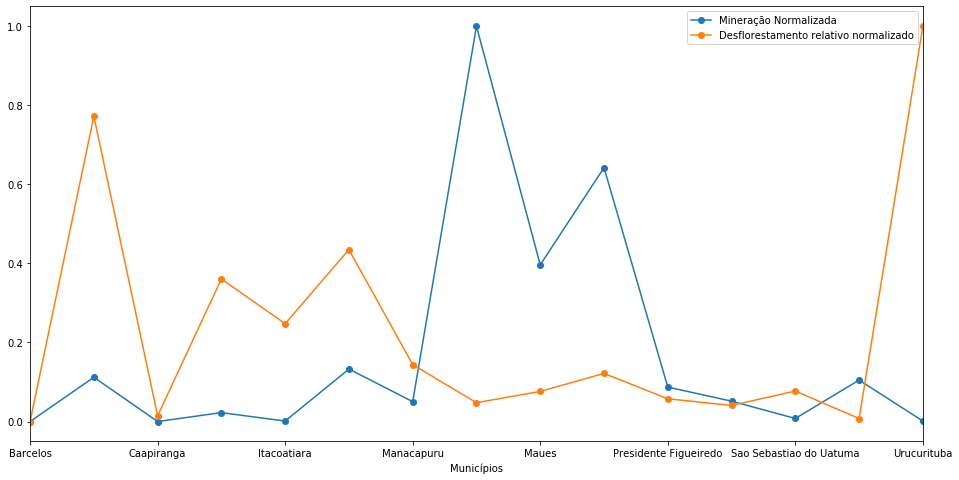

In [25]:
df_mining.plot('Municípios', [NORM_MINING, NORM_DEFOREST], marker='o', figsize=(16,8))

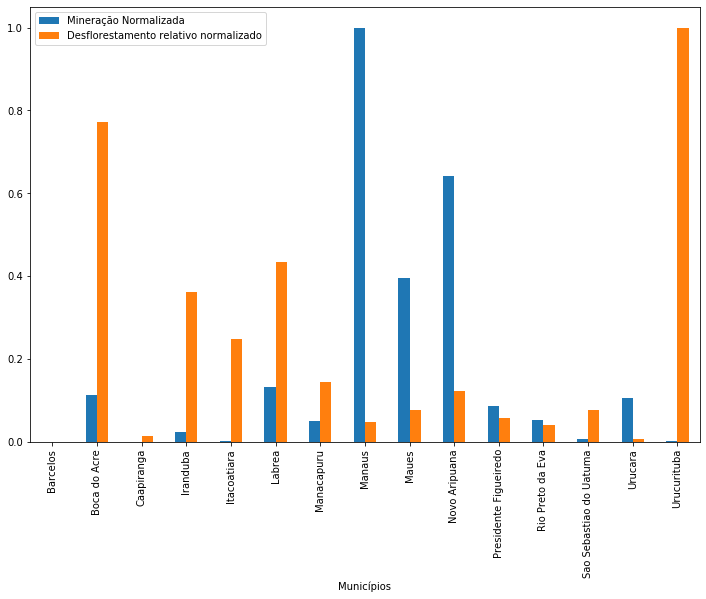

In [26]:
df_mining.plot.bar('Municípios', [NORM_MINING, NORM_DEFOREST], figsize=(12,8))

## Tendências: mineração x desflorestamento
Após eliminar os registros com dados ausentes e olhando para o crescimento dos valores de mineração e desflorestamento relativo, não é possível estabelecer nenhuma correlação positiva ou negativa entre as duas atividades. Há locais com atividade mineradora intensa e baixo desflorestamento, mas também há vários lugares com atividade mineradora baixa e baixo desflorestamento. Vamos olhar como esses dados estão posicionados em relação às médias dessas grandezas neste conjunto.

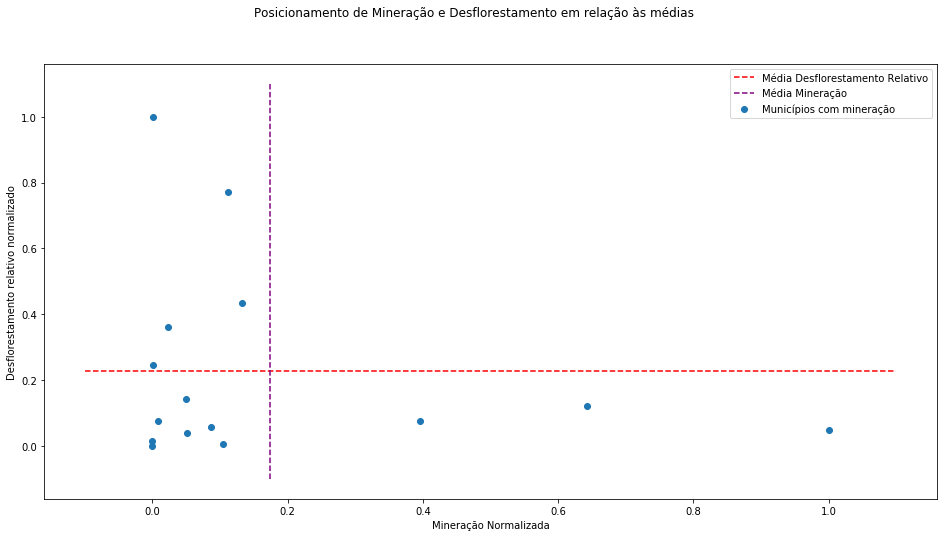

In [27]:
fig, ax = plt.subplots(figsize=(16,8))
ax.set_xlabel(NORM_MINING)
ax.set_ylabel(NORM_DEFOREST)

#fig = plt.figure(figsize=(16,8))
fig.suptitle("Posicionamento de Mineração e Desflorestamento em relação às médias ")
mean_deforest_mining = df_mining[NORM_DEFOREST].mean()
total_mining_cities = df_mining.shape[0]
samples = np.linspace(-0.1, 1.1, total_mining_cities)

plt.scatter(df_mining[NORM_MINING], df_mining[NORM_DEFOREST], label='Municípios com mineração')
# marca a média de desflorestamento em vermelho
plt.plot(samples, [mean_deforest_mining]*total_mining_cities, '--', color='red', label='Média Desflorestamento Relativo')
# marca a média de mineração em 
plt.plot([df_mining[NORM_MINING].mean()]*total_mining_cities, samples, '--', color='purple', label='Média Mineração')
ax.legend()

Olhando para a divisão no gráfico, podemos ver a média de desflorestamento e a média de mineração calculada somente com os municípios que possuem dados sobre mineração. Todos os municípios que tem mineração acima desta nova média, possuem atividade mineradora abaixo da média; contudo, a maior parte dos demais municípios também apresentam mineração abaixo da média, com apenas alguns poucos expoentes da atividade mineradora. Assim, mesmo nesta visão, não é possível estabelecer uma ligação entre a atividade de mineração e o desflorestamento nos municípios do Amazonas.

In [28]:
df_not_mining = df_forest[df_forest[MINERACAO].isnull()].fillna(0)
df_not_mining.head()

,Municípios,Agricultura Anual,Área não Observada,Área Urbana,Desflorestamento 2014,Floresta,Mineração,codigo_ibge,latitude,longitude,codigo_uf,uf,estado,Desflorestamento Relativo,Desflorestamento > Média
0,Alvaraes,0.0,0.07,1.90,2.75,5415.56,0.0,1300029,-3.22727,-64.8007,13,AM,Amazonas,0.000508,False
1,Amatura,0.0,0.00,2.05,0.36,4220.22,0.0,1300060,-3.37455,-68.2005,13,AM,Amazonas,0.000085,False
2,Anama,0.0,0.86,0.89,0.44,2001.85,0.0,1300086,-3.56697,-61.3963,13,AM,Amazonas,0.000220,False
3,Anori,0.0,0.15,2.77,0.59,4646.53,0.0,1300102,-3.74603,-61.6575,13,AM,Amazonas,0.000127,False
4,Apui,0.0,6.71,5.91,80.19,51396.43,0.0,1300144,-7.19409,-59.8960,13,AM,Amazonas,0.001560,True


In [29]:
#codigo de plot
plt.figure(figsize=(8,8))

plt.scatter(df_mining['longitude'], df_mining['latitude'],  
            s=df_mining[MINERACAO]*50,
            c = 'purple')

plt.scatter(df_not_mining['longitude'], df_not_mining['latitude'],  
           s=df_not_mining[MINERACAO]+30,
            c = 'violet')

#transforma o plot em localizações no mapa
mplleaflet.display()

# Mapa 3
Os pontos violeta claro representam os municípios em que os dados sobre mineração estão ausentes, por isso todos tem o mesmo tamanho. Já os dados em violeta escuro representam os municípios com dados sobre mineração e o tamanho do ponto é proporcional ao valor do indicador mineração.

In [30]:
plt.figure(figsize=(8,8))

plt.scatter(df_mining['longitude'], df_mining['latitude'],  
            s=df_mining[MINERACAO]*50,
            c = 'purple')

plt.scatter(df_not_mining['longitude'], df_not_mining['latitude'],  
           s=df_not_mining[MINERACAO]+30,
            c = 'violet')

plt.scatter(g2['longitude'], g2['latitude'], marker='x',
            s=g2['Floresta']/SCALE_FACTOR,
            c = 'red', alpha=0.9)
#transforma o plot em localizações no mapa
mplleaflet.display()

## Conclusão
No último mapa, adicionamos um indicador de desflorestamento acima da média geral. Os municípios que se enquadram neste critério estão representados com o "X" vermelho proporcional ao tamanho da floresta entre eles.

Com base nos dados disponibilizados e após a análise das tabelas e gráficos, conclui-se que não havia correlação entre a atividade de mineração e o desflorestamento nos municípios do Amazonas em 2014.